<a href="https://colab.research.google.com/github/AndreyDyachkov/Data_analytics_with_Python_2/blob/main/AB-tests_accident_insurance_products/AB_test_accident_insurance_product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B test of a product modification in accident insurance

### Background

A specific accident insurance product had a high frequency and high severity (average loss per claim), presumably due to fraud. In order to eradicate fraud the insurance program was cut and restrictions on sales were implemented.

### Goal

Estimate the impact of change in sales policy and contract terms on frequency and severity.

### Tasks

1. Define two cohorts of customers: those who bought a contract before the change and after it.
2. Compare the average loss in cohorts.
3. Compare frequency in cohorts.
4. Calculate the statistical significance of the differences.

### Results

We found a statistically significant difference in average loss per client (p<0.05). However, frequency didn't change a lot.

### Imports and data processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_analytics_with_Python_2/AB-tests_accident_insurance_products/data/accident_data.xlsx')
df.head()

,contract_id,start_date,end_date,GPW,DAC,Loss,count_loss,RBNS,count_rbns
0,SI-E048-0001877,2021-02-27,2022-02-26,2999,1649.0,-500000.0,1.0,NaN,NaN
1,SI-102-MЗ-023060,2021-05-13,2022-05-12,1599,1231.0,-250000.0,1.0,NaN,NaN
2,SI-R031-0000136,2022-02-08,2023-02-07,3000,NaN,-173000.0,1.0,NaN,NaN
3,SI-E030-0001418,2021-06-09,2022-06-08,2999,2309.0,-160000.0,3.0,NaN,NaN
4,SI-H030-0005506,2021-12-20,2022-12-19,2999,2309.0,-150000.0,1.0,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12360 entries, 0 to 12359
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   contract_id  12360 non-null  object        
 1   start_date   12360 non-null  datetime64[ns]
 2   end_date     12360 non-null  datetime64[ns]
 3   GPW          12360 non-null  int64         
 4   DAC          12052 non-null  float64       
 5   Loss         144 non-null    float64       
 6   count_loss   144 non-null    float64       
 7   RBNS         39 non-null     float64       
 8   count_rbns   39 non-null     float64       
dtypes: datetime64[ns](2), float64(5), int64(1), object(1)
memory usage: 869.2+ KB


Remove unnecessary periods

In [ ]:
df = df[(df['start_date']>='2021-01-01') & (df['start_date']<'2023-04-01')]

In [ ]:
df.describe()

,GPW,DAC,Loss,count_loss,RBNS,count_rbns
count,12120.000000,11818.000000,144.000000,144.000000,39.000000,39.0
mean,1933.268482,1457.147148,-34710.777778,1.083333,-46371.794872,1.0
std,1064.449818,564.258223,53642.452292,0.301511,107864.298149,0.0
min,-13800.000000,-1231.000000,-500000.000000,1.000000,-500000.000000,1.0
25%,1599.000000,1231.000000,-42500.000000,1.000000,-22500.000000,1.0
50%,1599.000000,1231.000000,-15000.000000,1.000000,-15000.000000,1.0
75%,2100.000000,1617.000000,-9562.500000,1.000000,-15000.000000,1.0
max,6900.000000,4485.000000,-3000.000000,3.000000,-1000.000000,1.0


Remove negative GPW ( cancelations show in this way)

In [ ]:
df = df[(df['GPW']>0)]

Change sign for losses and RBNS

In [ ]:
df['Loss'] = df['Loss'].abs()
df['RBNS'] = df['RBNS'].abs()

Fill empty values with 0

In [ ]:
df.fillna(0, inplace=True)

### EDA

Let's group by quarter and also combine losses and RBNS and calculate: LR, frequency and average loss per policy

In [ ]:
#df['start_date_month'] = df['start_date'].astype('datetime64[M]')
df['start_date_quarter'] = df['start_date'].dt.to_period('Q')
df['Loss+RBNS'] = df['Loss'] + df['RBNS']
df['count_claims'] = df['count_loss'] + df['count_rbns']
df.head()

,contract_id,start_date,end_date,GPW,DAC,Loss,count_loss,RBNS,count_rbns,start_date_quarter,Loss+RBNS,count_claims
0,SI-E048-0001877,2021-02-27,2022-02-26,2999,1649.0,500000.0,1.0,0.0,0.0,2021Q1,500000.0,1.0
1,SI-102-MЗ-023060,2021-05-13,2022-05-12,1599,1231.0,250000.0,1.0,0.0,0.0,2021Q2,250000.0,1.0
2,SI-R031-0000136,2022-02-08,2023-02-07,3000,0.0,173000.0,1.0,0.0,0.0,2022Q1,173000.0,1.0
3,SI-E030-0001418,2021-06-09,2022-06-08,2999,2309.0,160000.0,3.0,0.0,0.0,2021Q2,160000.0,3.0
4,SI-H030-0005506,2021-12-20,2022-12-19,2999,2309.0,150000.0,1.0,0.0,0.0,2021Q4,150000.0,1.0


In [ ]:
df_grouped = df.groupby(['start_date_quarter'], as_index=False).agg(count_contract_id=('contract_id','count'),
                                                                     total_gpw=('GPW','sum'),
                                                                     total_ar=('DAC','sum'),
                                                                     total_loss=('Loss+RBNS','sum'),
                                                                     avg_loss_per_policy=('Loss+RBNS','mean'),
                                                                     total_claims=('count_claims','sum'))

df_grouped['LR'] = -df_grouped['total_loss'] / df_grouped['total_gpw']
df_grouped['frequency'] = df_grouped['total_claims'] / df_grouped['count_contract_id']
df_grouped

,start_date_quarter,count_contract_id,total_gpw,total_ar,total_loss,avg_loss_per_policy,total_claims,LR,frequency
0,2021Q1,1693,3181037,2281520.0,1348602.0,796.575310,40.0,-0.423950,0.023627
1,2021Q2,1795,3304557,2377698.0,1280000.0,713.091922,23.0,-0.387344,0.012813
2,2021Q3,1691,3162516,2306386.0,1232500.0,728.858664,16.0,-0.389721,0.009462
3,2021Q4,1562,2919334,2155296.0,915000.0,585.787452,33.0,-0.313428,0.021127
4,2022Q1,1122,2334961,1673143.0,720500.0,642.156863,20.0,-0.308570,0.017825
5,2022Q2,1137,2077149,1500726.0,335000.0,294.635004,22.0,-0.161279,0.019349
6,2022Q3,1301,2615660,1816930.0,684500.0,526.133743,28.0,-0.261693,0.021522
7,2022Q4,962,2436606,1732333.0,158750.0,165.020790,9.0,-0.065152,0.009356
8,2023Q1,690,1955677,1380226.0,132000.0,191.304348,4.0,-0.067496,0.005797


#### Visualization

Let's look at basic insurance metrics: LR, GPW

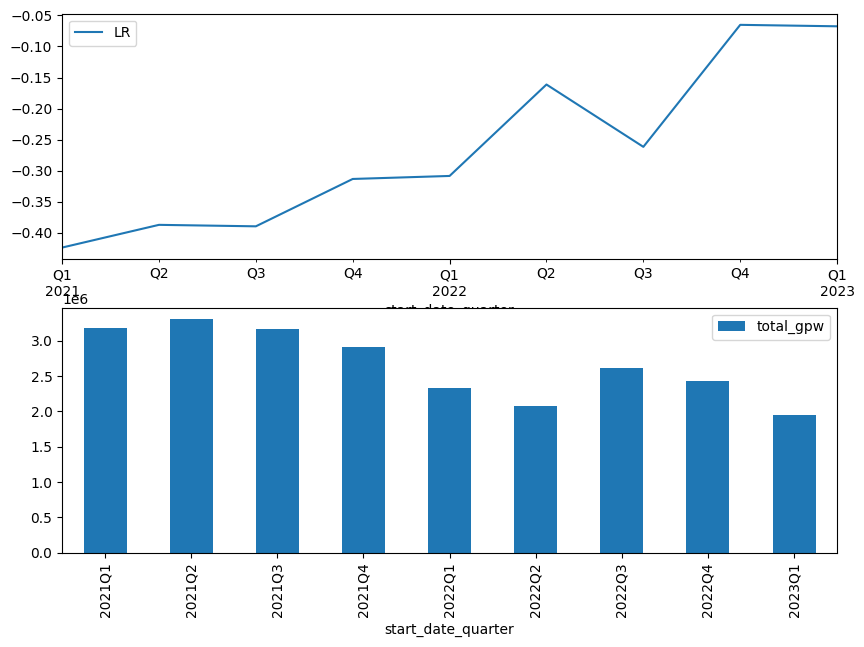

In [ ]:
figure, axes = plt.subplots(2, 1, figsize=(10, 7))

df_grouped.plot(x="start_date_quarter", y="LR", kind="line", ax=axes[0])
df_grouped.plot(x="start_date_quarter", y="total_gpw", kind="bar", ax=axes[1])

plt.show()

We can see that in 2022 LR decreased which could be a result of strict measures. However, GPW decreased as well, which is not good, but it can be a result of the same measures. Let's look at frequency and average loss per policy.

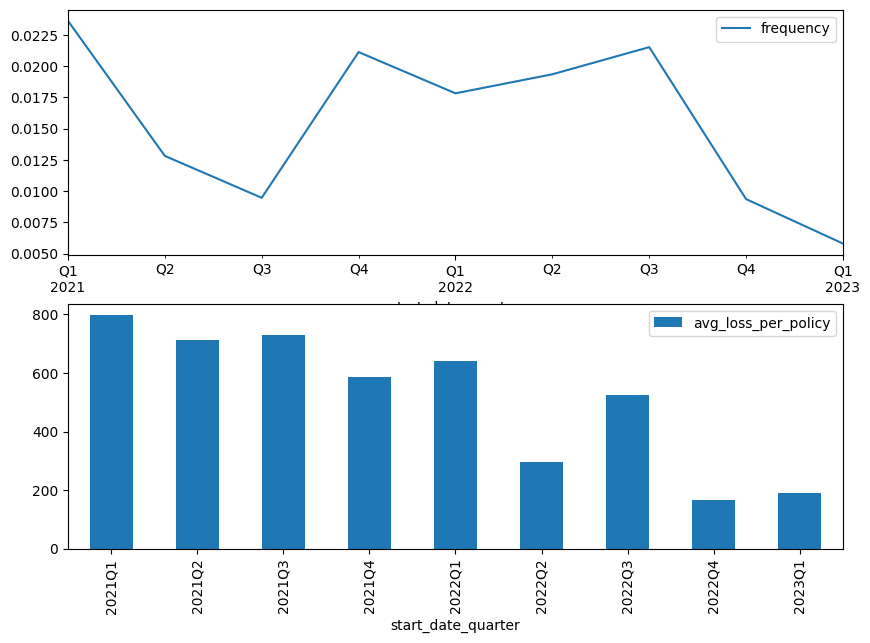

In [ ]:
figure, axes = plt.subplots(2, 1, figsize=(10, 7))

df_grouped.plot(x="start_date_quarter", y="frequency", kind="line", ax=axes[0])
df_grouped.plot(x="start_date_quarter", y="avg_loss_per_policy", kind="bar", ax=axes[1])

plt.show()

We don't see the drop in frequency in 2022, on contrary the measure increased. As for the average loss per policy there is a positive tendency, however we should test its significance.

### AB test of average loss per customer

Let's look at the distribution of losses. It shoud be lognormal.

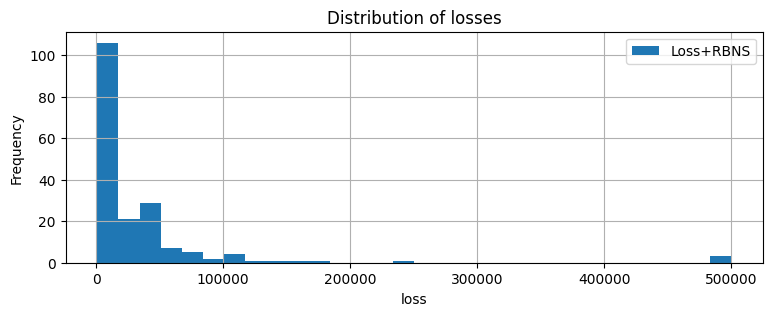

In [ ]:
df[df['Loss+RBNS']>0].plot(kind='hist', y='Loss+RBNS', bins=30, grid=True, figsize=(9,3), title='Distribution of losses')
plt.xlabel('loss')
plt.ylabel('Frequency')
plt.show()

Let's draw a boxplot as well

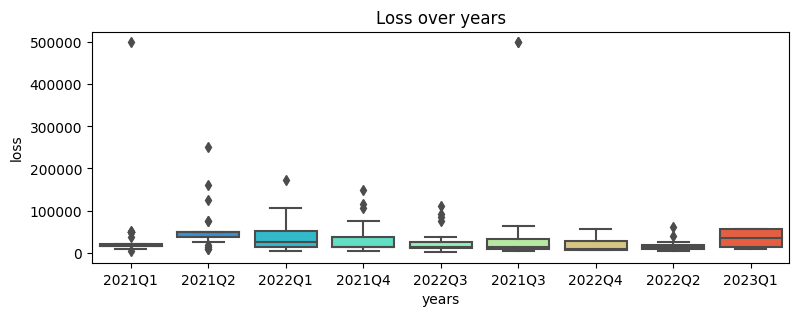

In [ ]:
plt.figure(figsize=(9,3))
sns.boxplot(x='start_date_quarter', y='Loss+RBNS', data=df[df['Loss+RBNS']>0], palette='rainbow').set(
    xlabel='years',
    ylabel='loss')
plt.title('Loss over years')
plt.show()

Let's make a dataset with losses only, remove outliers and add logarithm of losses to come to normal distribution

In [ ]:
Q1,Q3 = df[df['Loss+RBNS']>0]['Loss+RBNS'].quantile(0.25), df[df['Loss+RBNS']>0]['Loss+RBNS'].quantile(0.75)
IQR = Q3 - Q1
cut_off = IQR * 1.5
lower, upper = Q1 - cut_off, Q3 + cut_off
print("Lower cut off:", lower,"Upper cut off:", upper)

Lower cut off: -28750.0 Upper cut off: 81250.0


In [ ]:
fixed_df = df[(df['Loss+RBNS'] < upper) & (df['Loss+RBNS']>0)]
fixed_df['ln_loss'] = np.log(fixed_df['Loss+RBNS'])
fixed_df

<ipython-input-16-9f34e9f7039f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed_df['ln_loss'] = np.log(fixed_df['Loss+RBNS'])


,contract_id,start_date,end_date,GPW,DAC,Loss,count_loss,RBNS,count_rbns,start_date_quarter,Loss+RBNS,count_claims,ln_loss
12,SI-E030-0001216,2021-04-24,2022-04-23,2999,2309.0,75000.0,1.0,0.0,0.0,2021Q2,75000.0,1.0,11.225243
13,SI-E030-0001416,2021-06-09,2022-06-08,2999,2309.0,75000.0,1.0,0.0,0.0,2021Q2,75000.0,1.0,11.225243
14,FD-E030-0001982,2021-10-22,2022-10-21,1599,1231.0,75000.0,1.0,0.0,0.0,2021Q4,75000.0,1.0,11.225243
15,SI-R031-0000139,2022-02-13,2023-02-12,2700,0.0,75000.0,1.0,0.0,0.0,2022Q1,75000.0,1.0,11.225243
16,SI-E048-0002682,2022-09-14,2023-09-13,2999,1649.0,75000.0,1.0,0.0,0.0,2022Q3,75000.0,1.0,11.225243
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,SI-E030-0003244,2022-08-02,2023-08-01,2999,2309.0,0.0,0.0,10000.0,1.0,2022Q3,10000.0,1.0,9.210340
10035,SI-E030-0003563,2022-09-03,2023-09-02,2999,2309.0,0.0,0.0,20000.0,1.0,2022Q3,20000.0,1.0,9.903488
10337,SI-R031-0000186,2022-09-22,2023-09-21,5400,0.0,0.0,0.0,1000.0,1.0,2022Q3,1000.0,1.0,6.907755
11890,SI-E057-0000282,2023-02-24,2024-02-23,3950,0.0,0.0,0.0,55000.0,1.0,2023Q1,55000.0,1.0,10.915088


check distribution

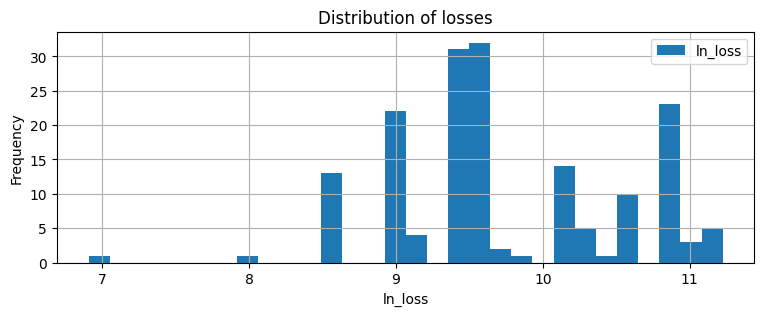

In [ ]:
fixed_df.plot(kind='hist', y='ln_loss', bins=30, grid=True, figsize=(9,3), title='Distribution of losses')
plt.xlabel('ln_loss')
plt.ylabel('Frequency')
plt.show()

Looks good to use t-test. We create two group: control - before the product modification, test - after it.

In [ ]:
control_sample = fixed_df[fixed_df['start_date'].dt.year==2021][['Loss+RBNS','ln_loss']]
control_sample

,Loss+RBNS,ln_loss
12,75000.0,11.225243
13,75000.0,11.225243
14,75000.0,11.225243
17,62500.0,11.042922
20,50602.0,10.831746
...,...,...
532,15000.0,9.615805
533,15000.0,9.615805
534,15000.0,9.615805
535,15000.0,9.615805


In [ ]:
test_sample = fixed_df[fixed_df['start_date'].dt.year==2022][['Loss+RBNS','ln_loss']]
test_sample

,Loss+RBNS,ln_loss
15,75000.0,11.225243
16,75000.0,11.225243
18,60000.0,11.002100
19,55000.0,10.915088
38,40000.0,10.596635
...,...,...
8907,25000.0,10.126631
9444,12500.0,9.433484
9610,10000.0,9.210340
10035,20000.0,9.903488


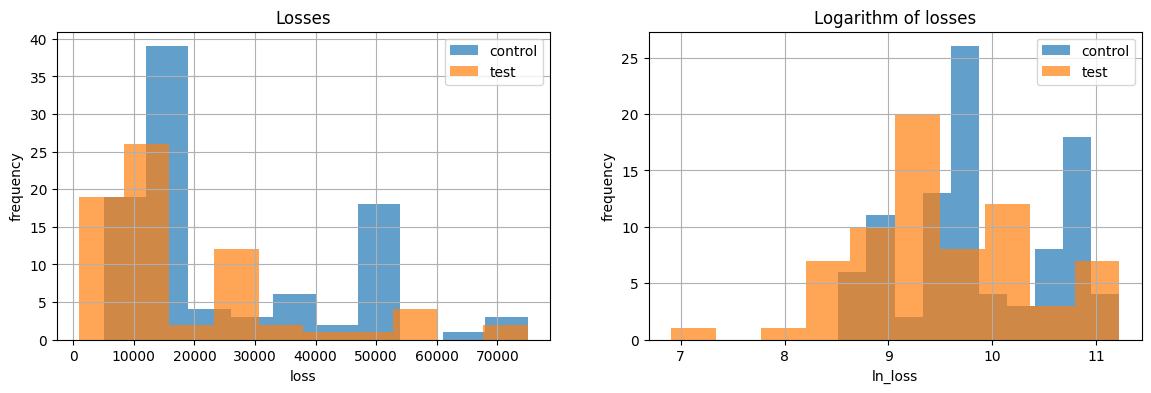

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.hist(control_sample['Loss+RBNS'], label = 'control', bins=10, alpha=0.7)
plt.hist(test_sample['Loss+RBNS'], label = 'test', bins=10, alpha=0.7)
plt.title('Losses')
plt.grid(True)
plt.legend()
plt.xlabel('loss')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.hist(control_sample['ln_loss'], label = 'control', bins=10, alpha=0.7)
plt.hist(test_sample['ln_loss'], label = 'test', bins=10, alpha=0.7)
plt.title('Logarithm of losses')
plt.grid(True)
plt.legend()
plt.xlabel('ln_loss')
plt.ylabel('frequency')
plt.show()

There is no much difference between two periods. Let's run t-test with alpha = 0.05

#### t-test

The difference of means:

In [ ]:
control_sample['Loss+RBNS'].mean() - test_sample['Loss+RBNS'].mean()

5643.751029748284

In [ ]:
test_sample['Loss+RBNS'].mean() / control_sample['Loss+RBNS'].mean() -1

-0.22612116552813288

In [ ]:
alpha = 0.05
results = st.ttest_ind(control_sample['ln_loss'], test_sample['ln_loss'], equal_var=True)
print('p-value:', round(results.pvalue,4))
print('t-statistic:', round(results.statistic,4))

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

p-value: 0.0203
t-statistic: 2.3432
We reject the null hypothesis


Let's check manually

In [ ]:
control_n = len(control_sample['ln_loss'])
test_n = len(test_sample['ln_loss'])

control_mean = control_sample['ln_loss'].mean()
test_mean = test_sample['ln_loss'].mean()

control_std = control_sample['ln_loss'].std()
test_std = test_sample['ln_loss'].std()

pooled_variance = (control_std**2 + test_std**2)/2

In [ ]:
t_value = (control_mean - test_mean) / ((pooled_variance/control_n) + (pooled_variance/test_n))**(1/2)
t_value

2.333210061338331

In [ ]:
Df = control_n + test_n - 2

In [ ]:
p_value = (1 - st.t.cdf(abs(t_value),df=Df))*2
p_value

0.020866057370770852

The drop in avg loss per customer is statistically significant (p<0.05)

### AB test of frequency

Since frequency is a ratio we can use z-test

In [ ]:
df_grouped['start_date_year'] = df_grouped['start_date_quarter'].dt.year
df_grouped

,start_date_quarter,count_contract_id,total_gpw,total_ar,total_loss,avg_loss_per_policy,total_claims,LR,frequency,start_date_year
0,2021Q1,1693,3181037,2281520.0,1348602.0,796.575310,40.0,-0.423950,0.023627,2021
1,2021Q2,1795,3304557,2377698.0,1280000.0,713.091922,23.0,-0.387344,0.012813,2021
2,2021Q3,1691,3162516,2306386.0,1232500.0,728.858664,16.0,-0.389721,0.009462,2021
3,2021Q4,1562,2919334,2155296.0,915000.0,585.787452,33.0,-0.313428,0.021127,2021
4,2022Q1,1122,2334961,1673143.0,720500.0,642.156863,20.0,-0.308570,0.017825,2022
5,2022Q2,1137,2077149,1500726.0,335000.0,294.635004,22.0,-0.161279,0.019349,2022
6,2022Q3,1301,2615660,1816930.0,684500.0,526.133743,28.0,-0.261693,0.021522,2022
7,2022Q4,962,2436606,1732333.0,158750.0,165.020790,9.0,-0.065152,0.009356,2022
8,2023Q1,690,1955677,1380226.0,132000.0,191.304348,4.0,-0.067496,0.005797,2023


In [ ]:
df_frequency = df_grouped.groupby('start_date_year', as_index=False)[['count_contract_id','total_claims']].sum()
df_frequency['frequency'] = df_frequency['total_claims'] / df_frequency['count_contract_id']
df_frequency

,start_date_year,count_contract_id,total_claims,frequency
0,2021,6741,112.0,0.016615
1,2022,4522,79.0,0.017470
2,2023,690,4.0,0.005797


There is almost no difference in frequency between 2022 and 2021. We don't need test it, but let's run z-test

#### z-test

In [ ]:
m_control = df_frequency[df_frequency['start_date_year']==2021]['total_claims'].values[0]
m_test = df_frequency[df_frequency['start_date_year']==2022]['total_claims'].values[0]

n_control = df_frequency[df_frequency['start_date_year']==2021]['count_contract_id'].values[0]
n_test = df_frequency[df_frequency['start_date_year']==2022]['count_contract_id'].values[0]

In [ ]:
p_test = m_test / n_test
p_control = m_control / n_control
p_pooled = (m_test + m_control) / (n_control + n_test)
f'p_test: {round(p_test,4)}, p_control: {round(p_control,4)}, p_pooled: {round(p_pooled,4)}'

'p_test: 0.0175, p_control: 0.0166, p_pooled: 0.017'

In [ ]:
z_value = (p_control - p_test) / (p_pooled*(1-p_pooled)*(1/n_control+1/n_test))**(1/2)
z_value

-0.34466262743033393

In [ ]:
p_value = (1-st.norm.cdf(abs(z_value)))*2
print('p-value: ', p_value)

p-value:  0.7303480173908923


The is no significant difference as we expected before